In [22]:
#extracting data from flicker data set.
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add,BatchNormalization, Activation, LayerNormalization,Add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import save_model
import tensorflow_hub as hub
import pickle
tokenizer=Tokenizer()
# from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add, BatchNormalization, Activation, LayerNormalization
# save the iris classification model as a pickle file
# tensor flow package/
#    #keras/
#       #layers.py - Dense,flatten...
#       #models.py - save_model,load_model
#       #optimizers -adam ??
#pandas take only lists

In [23]:
#extracting captions data
import string 
import re
filepath=r"C:\Users\mvvha\OneDrive\Desktop\soc\archive (1)\captions.txt"
cap_data=pd.read_csv(filepath)
def insert_start_end(string):
    s_1="startseq "
    s_2=" endseq"
    return s_1+string+s_2
punch=string.punctuation
def remove_punc(text):
     return text.translate(str.maketrans(" "," ",punch))
def preprocess_text(t_data):
    t_data["caption"]=t_data["caption"].str.lower()
    t_data['caption'] =t_data['caption'].apply(lambda x: x.replace("[^A-Za-z]"," "))
    t_data['caption'] =t_data['caption'].apply(lambda x: re.sub(r"\s+"," ",x))
    t_data["caption"]=t_data["caption"].apply(remove_punc)
    t_data["caption"]=t_data['caption'].apply(insert_start_end)
preprocess_text(cap_data)
print(cap_data["caption"].sample(n=2))
tokenizer.fit_on_texts(cap_data['caption'])
cap_data['sequences']=tokenizer.texts_to_sequences(cap_data['caption'])
max_length=max(len(seq) for seq in cap_data['sequences'])
print(max_length)
cap_data['pad_sequences']=list(pad_sequences(cap_data['sequences'],maxlen=max_length,padding="post"))
print(cap_data['pad_sequences'].sample(n=2))
vocab_size=len(tokenizer.word_index)+1#for padding token
start_token_present = 'startseq' in tokenizer.word_index
end_token_present = 'endseq' in tokenizer.word_index

print(f"<start> token present: {start_token_present}")
print(f"<end> token present: {end_token_present}")

# Optionally, print the indices of these tokens
if start_token_present:
    print(f"<start> token index: {tokenizer.word_index['startseq']}")
if end_token_present:
    print(f"<end> token index: {tokenizer.word_index['endseq']}")

38758    startseq a person with a backpack stands on a ...
19038    startseq the motocross bike is doing a jump in...
Name: caption, dtype: object
38
2334     [2, 1, 11, 84, 119, 4, 5, 296, 274, 54, 294, 3...
33226    [2, 1, 11, 107, 8, 1, 15, 37, 8, 205, 7, 196, ...
Name: pad_sequences, dtype: object
<start> token present: True
<end> token present: True
<start> token index: 2
<end> token index: 3


In [24]:
images = cap_data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.90*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = cap_data[cap_data['image'].isin(train_images)]
test = cap_data[cap_data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [25]:
#extracting features from image.
def extract_features(images_directory):
    pre_trainedmodel=tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    pooling='max',
    input_tensor=None,
    input_shape=(224,224,3),
    classifier_activation="softmax",)
    for layer in pre_trainedmodel.layers:
        layer.trainable=False
    model=tf.keras.Model(inputs=pre_trainedmodel.input,outputs=pre_trainedmodel.output)
    features_dict = {}
    features_array=[]
    img_name_array=[]
    for img_name in os.listdir(images_directory):
        img_path = os.path.join(images_directory, img_name)
        if os.path.isfile(img_path):
            #preprocessing image
            img=cv2.imread(img_path)
            img_resized=cv2.resize(img,(224,224))
            img_expanded=np.expand_dims(img_resized,axis=0)
            img_array = tf.keras.applications.xception.preprocess_input(img_expanded)
            features = model.predict(img_array,verbose=0)
            features_array.append(features)
            img_name_array.append(img_name)
    features_dict["image"]=img_name_array
    features_dict["features"] = features_array
    return features_dict
directory=r"C:\Users\mvvha\OneDrive\Desktop\soc\archive (1)\Images"
image_features_dict=extract_features(directory)
print(len(image_features_dict["features"][0]))
data_to_merge=pd.DataFrame(image_features_dict)
data_to_merge.to_csv("features.csv",index=False)
total_data=pd.merge(cap_data,data_to_merge,on="image",how="inner")

1


In [26]:
print(image_features_dict['features'][0].shape)
import numpy as np
from tensorflow.keras.utils import Sequence
class CustomDataGenerator(Sequence):
    def __init__(self, data, max_length, vocab_size, image_features_dict, batch_size=32, shuffle=True):
        self.data = data.copy()
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.image_features_dict = image_features_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def on_epoch_end(self):
        if self.shuffle:
            self.data = self.data.sample(frac=1).reset_index(drop=True)
    def __len__(self):
        return len(self.data) // self.batch_size
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_data = self.data.iloc[start_idx:end_idx]
        X1, X2, y = self.__generate_batch(batch_data)
        return (X1, X2), y
    
    def __generate_batch(self, batch_data):
        image_features, input_sequence, output_sequence = [], [], []
        
        for row in batch_data.itertuples(index=False, name='Pandas'):
            sequence = row.pad_sequences
            image_id = row.image
            idx = self.image_features_dict["image"].index(image_id)
            img_f = self.image_features_dict["features"][idx].reshape(-1)
            
            for i in range(1, len(sequence)):
                in_seq, out_seq = sequence[:i], sequence[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                image_features.append(img_f)
                input_sequence.append(in_seq)
                output_sequence.append(out_seq)
                
        return np.array(image_features), np.array(input_sequence), np.array(output_sequence)


(1, 2048)


In [31]:
#model creation
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [32]:
batch_size = 32
epochs = 10

# Create an instance of the model
model = define_model(vocab_size, max_length)
# checkpoint_path = "./final_model.weights.h5"
model_name = "custom_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss", 
                            mode="min",
                            save_best_only = True,
                            verbose=1)
train_data = cap_data  # Replace with your actual training data
# steps_per_epoch = len(train_data) // batch_size

In [34]:
model=define_model(vocab_size, max_length)
model.summary()
train_datagenerator=CustomDataGenerator(train,max_length, vocab_size,image_features_dict,batch_size)
test_datagenerator=CustomDataGenerator(test,max_length, vocab_size,image_features_dict,batch_size)
# history=model.fit(data1,epochs=10)
history = model.fit(train_datagenerator,epochs=epochs,validation_data=test_datagenerator,callbacks=[checkpoint])
# for i in range(steps_per_epoch):

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 38, 256)   │  2,260,736 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 2048)      │          0 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 38, 256)   │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_18        │ (None, 38)        │          0 │ input_layer_17[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 256)       │    525,312 │ dropout_9[0][0],  │
│                     │                   │            │ not_equal_18[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_100 (Add)       │ (None, 256)       │          0 │ dense_12[0][0],   │
│                     │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     65,792 │ add_100[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 8831)      │  2,269,567 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,645,951 (21.54 MB)

 Trainable params: 5,645,951 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7415 - loss: 1.7231
Epoch 1: val_loss improved from inf to 1.11582, saving model to custom_model.keras
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 2672s 2s/step - accuracy: 0.7415 - loss: 1.7227 - val_accuracy: 0.7889 - val_loss: 1.1158
Epoch 2/10
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7945 - loss: 1.0397
Epoch 2: val_loss improved from 1.11582 to 1.04687, saving model to custom_model.keras
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 1287s 1s/step - accuracy: 0.7945 - loss: 1.0397 - val_accuracy: 0.7970 - val_loss: 1.0469
Epoch 3/10
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.8027 - loss: 0.9336
Epoch 3: val_loss improved from 1.04687 to 1.02528, saving model to custom_model.keras
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 1144s 1s/step - accuracy: 0.8027 - loss: 0.9336 - val_accuracy: 0.8006 - val_loss: 1.0253
Epoch 4/10
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 0.8085 - loss: 0.8685
Epoch 4: val_loss did not 

In [41]:
#interupting the above code after 9 epochs ,since no update in val_loss.
def preprocess_image(img_path):
    img=cv2.imread(img_path)
    img_resized=cv2.resize(img,(224,224))
    img_expanded=np.expand_dims(img_resized,axis=0)
    img_array = tf.keras.applications.xception.preprocess_input(img_expanded)
    pre_trainedmodel=tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    pooling='max',
    input_tensor=None,
    input_shape=(224,224,3),
    classifier_activation="softmax",)
    for layer in pre_trainedmodel.layers:
        layer.trainable=False
    model_12=tf.keras.Model(inputs=pre_trainedmodel.input,outputs=pre_trainedmodel.output)
    features = model_12.predict(img_array)
    return features
# generate caption for an image
def generate_caption(image_path, network,max_caption_length=20):
    img = preprocess_image(image_path)
    input_sequence = ['startseq']  # Start with <start> token
    while len(input_sequence) < max_caption_length:
        sequence = tokenizer.texts_to_sequences([input_sequence])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict next word
        predictions = network.predict([img, np.array(sequence)])
        predicted_word_index = np.argmax(predictions)

        # Stop generation if <end> token is predicted
        if predicted_word_index == tokenizer.word_index["endseq"]:
            break

        # Append predicted word to input sequence
        predicted_word = tokenizer.index_word[predicted_word_index]
        input_sequence.append(predicted_word)
    # Remove <start> and <end> tokens and join words
    generated_caption = ' '.join(input_sequence[1:])  # Exclude <start> token
    return generated_caption

Selected image path: C:\Users\mvvha\OneDrive\Desktop\soc\german.jpeg


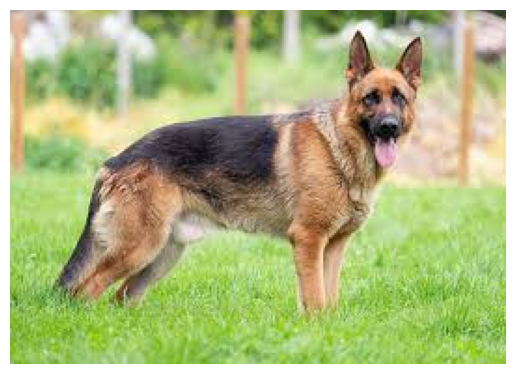

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
a brown dog is running through a grassy field


In [42]:
reconstructed_model = keras.models.load_model(
    "custom_model.keras",
    custom_objects=None
)
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
directory = input("path of image : ")
image_path=directory
# # Example usage (assuming the directory exists)
# files = os.listdir(directory)
# print(f"Files in the directory: {files}")

def show_image(image_path):
    img = mpimg.imread(image_path)
    imgplot = plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
# Example usage
if image_path:
    print(f"Selected image path: {image_path}")
    show_image(image_path)
    print(generate_caption(image_path,reconstructed_model))

else:
    print("No image selected.")


